In [ ]:
!pip install transformers datasets accelerate peft bitsandbytes wandb lightning --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import wandb
import random
import json
import ast
import re
from typing import Any, List, Dict

import datasets
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from huggingface_hub import HfApi, HfFolder, notebook_login

from nltk import edit_distance

import lightning as L
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger

import transformers
from transformers import AutoProcessor
from transformers import PaliGemmaForConditionalGeneration
from transformers import BitsAndBytesConfig

from peft import LoraConfig
from peft import get_peft_model

In [ ]:
notebook_login()

In [ ]:
REPO_ID = "google/paligemma-3b-pt-224"
DATASET_PATH = "mychen76/invoices-and-receipts_ocr_v1"
FINETUNED_MODEL_PATH = "subhuatharva/paligemma_receipts_OCR_dataset"
MAX_LENGTH = 512
WANDB_PROJECT = "Paligemma_Receipts_OCR"
WANDB_NAME = "Receipts_OCR"

In [ ]:
dataset = load_dataset(DATASET_PATH)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/125 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/70 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'parsed_data', 'raw_data'],
        num_rows: 2043
    })
    test: Dataset({
        features: ['image', 'id', 'parsed_data', 'raw_data'],
        num_rows: 125
    })
    valid: Dataset({
        features: ['image', 'id', 'parsed_data', 'raw_data'],
        num_rows: 70
    })
})

In [ ]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2481x3508>,
 'id': '0',
 'parsed_data': '{"xml": "", "json": "{\'header\': {\'invoice_no\': \'40378170\', \'invoice_date\': \'10/15/2012\', \'seller\': \'Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228\', \'client\': \'Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601\', \'seller_tax_id\': \'958-74-3511\', \'client_tax_id\': \'998-87-7723\', \'iban\': \'GB77WRBQ31965128414006\'}, \'items\': [{\'item_desc\': \\"Leed\'s Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter\\", \'item_qty\': \'1,00\', \'item_net_price\': \'7,50\', \'item_net_worth\': \'7,50\', \'item_vat\': \'10%\', \'item_gross_worth\': \'8,25\'}], \'summary\': {\'total_net_worth\': \'$7,50\', \'total_vat\': \'$0,75\', \'total_gross_worth\': \'$8,25\'}}", "kie": ""}',
 'raw_data': '{"ocr_words": "[\'Invoice no: 40378170\', \'Date of issue:\', \'10/15/2012\', \'Seller:\', \'Client:\', \'Patel, Tho

### Creating PyTorch Dataset
Pytorch dataset creates a tensor dataset which can be directly passed to the model and makes the data preprocessing, data augmentation and other preprocessing steps easier.

In [ ]:
def json_to_token(obj: Any, sort_json_key: bool = True):
  ### Converting JSON to Token
  if type(obj) == dict:
    if len(obj) == 1 and 'text_sequence' in obj:
      return obj['text_sequence']
    else:
      output = ""
      if sort_json_key:
        keys = sorted(obj.keys(), reverse = True)
      else:
        keys = obj.keys()

      for k in keys:
        token = json_to_token(obj[k], sort_json_key)
        if token is not None:
          output += (fr"<s_{k}>" + token + fr"</s{k}>")

      return output
  elif type(obj) == list:
    return r"<sep/>".join([json_to_token(item, sort_json_key) for item in obj])
  else:
    obj = str(obj)
    return obj

In [ ]:
gt_token_sequence = []
for i in range(10):
  sample = dataset['train'][i]
  samplep1 = ast.literal_eval(re.search('({.+})', sample["parsed_data"]).group(0))
  final_sample = ast.literal_eval(re.search('({.+})', samplep1["json"]).group(0))


  d_doc = json_to_token(final_sample['header']) + json_to_token(final_sample['items'][0]) + json_to_token(final_sample['summary'])
  gt_token_sequence.append(d_doc)

In [ ]:
gt_token_sequence[0]

"<s_seller_tax_id>958-74-3511</sseller_tax_id><s_seller>Patel, Thompson and Montgomery 356 Kyle Vista New James, MA 46228</sseller><s_invoice_no>40378170</sinvoice_no><s_invoice_date>10/15/2012</sinvoice_date><s_iban>GB77WRBQ31965128414006</siban><s_client_tax_id>998-87-7723</sclient_tax_id><s_client>Jackson, Odonnell and Jackson 267 John Track Suite 841 Jenniferville, PA 98601</sclient><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>7,50</sitem_net_worth><s_item_net_price>7,50</sitem_net_price><s_item_gross_worth>8,25</sitem_gross_worth><s_item_desc>Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil Cutter</sitem_desc><s_total_vat>$0,75</stotal_vat><s_total_net_worth>$7,50</stotal_net_worth><s_total_gross_worth>$8,25</stotal_gross_worth>"

In [ ]:
class CustomDataset(Dataset):
  def __init__(self,
               dataset_path: str,
               split: str = "train",
               sort_json_key: bool = True,
               ):
    super().__init__()

    self.split = split
    self.sort_json_key = sort_json_key

    self.dataset = load_dataset(dataset_path, split=self.split)
    self.dataset_length = len(self.dataset)

    self.gt_token_sequence = []
    for sample in self.dataset:
      samplep1 = ast.literal_eval(re.search('({.+})', sample["parsed_data"]).group(0))
      final_sample = ast.literal_eval(re.search('({.+})', samplep1["json"]).group(0))
      if "header" not in samplep1.keys():
        d_doc = json_to_token(final_sample)
        self.gt_token_sequence.append(d_doc)
      else:
        d_doc = json_to_token(final_sample['header']) + json_to_token(final_sample['items'][0]) + json_to_token(final_sample['summary'])
        self.gt_token_sequence.append(d_doc)

  def json_to_token(self, obj: Any, sort_json_key: bool = True):
    ### Converting JSON to Token
    if type(obj) == dict:
      if len(obj) == 1 and 'text_sequence' in obj:
        return obj['text_sequence']
      else:
        output = ""
        if sort_json_key:
          keys = sorted(obj.keys(), reverse = True)
        else:
          keys = obj.keys()

        for k in keys:
          token = self.json_to_token(obj[k], sort_json_key)
          if token is not None:
            output += (fr"<s_{k}>" + token + fr"</s{k}>")

        return output
    elif type(obj) == list:
      return r"<sep/>".join([self.json_to_token(item, sort_json_key) for item in obj])
    else:
      obj = str(obj)
      return obj



  def __len__(self) -> int:
    return self.dataset_length

  def __getitem__(self, index: int) -> Dict:

   sample = self.dataset[index]

   # Input
   image = sample["image"]
   target_sequence = self.gt_token_sequence[index]

   return image, target_sequence

In [ ]:
train_dataset = CustomDataset(DATASET_PATH, split="train")
val_dataset = CustomDataset(DATASET_PATH, split="valid")

### Creating collate functions for Data Loader

The collate function finalizes the step of arranging data after using data loader to be sent the model as inputs. In this case we have the train collate function which prepares the inputs for the training data which includes the PROMPT + processed images + labels. For the evalution data, the collate function includes PROMPT + processed images and we further use this to predict the labels.

In [ ]:
processor = AutoProcessor.from_pretrained(REPO_ID)

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [ ]:
PROMPT = "extract JSON."

def train_collate_fn(examples):
  images = [example[0] for example in examples]
  texts = [PROMPT for _ in range(len(images))]
  target_sequences = [example[1] for example in examples]

  inputs = processor(text = texts,
                     images = images,
                     suffix = target_sequences,
                     return_tensors = "pt",
                     padding = True,
                     truncation = "only_second",
                     max_length = MAX_LENGTH,
                     tokenize_newline_separately = False)

  input_ids = inputs["input_ids"]
  token_type_ids = inputs["token_type_ids"]
  attention_mask = inputs["attention_mask"]
  pixel_values = inputs["pixel_values"]
  labels = inputs["labels"]

  return input_ids, token_type_ids, attention_mask, pixel_values, labels

In [ ]:
def eval_collate_fn(examples):
  images = [example[0] for example in examples]
  texts = [PROMPT for _ in range(len(images))]
  target_sequences = [example[1] for example in examples]

  inputs = processor(text = texts,
                     images = images,
                     return_tensors = "pt",
                     padding = True,
                     tokenize_newline_separately = False)

  input_ids = inputs["input_ids"]
  attention_mask = inputs["attention_mask"]
  pixel_values = inputs["pixel_values"]


  return input_ids, attention_mask, pixel_values, target_sequences

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=train_collate_fn)
input_ids, token_type_ids, attention_mask, pixel_values, labels = next(iter(train_dataloader))

In [ ]:

print(input_ids[0][-30:])
print(labels[0][-30:])

tensor([235315, 235276, 235276, 235265, 235276, 235276,    727,    542,    686,
        235298,   1869,   2577, 235256, 235298,    884, 235298,  22791, 235313,
        235274,    727,    542,    686, 235298,  22791,   2577, 235256, 235298,
           884, 235298,   1067])
tensor([235315, 235276, 235276, 235265, 235276, 235276,    727,    542,    686,
        235298,   1869,   2577, 235256, 235298,    884, 235298,  22791, 235313,
        235274,    727,    542,    686, 235298,  22791,   2577, 235256, 235298,
           884, 235298,   1067])


In [ ]:
for id, label in zip(input_ids[0][-30:], labels[0][-30:]):
  print(processor.decode([id.item()]), processor.decode([label.item()]))

9 9
0 0
0 0
. .
0 0
0 0
</ </
si si
tem tem
_ _
value value
>< ><
s s
_ _
item item
_ _
quantity quantity
> >
1 1
</ </
si si
tem tem
_ _
quantity quantity
>< ><
s s
_ _
item item
_ _
name name


In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=eval_collate_fn)
input_ids, attention_mask, pixel_values, labels = next(iter(val_dataloader))

### Lightning Module setup

This section is where we define the training and the validation steps. Lightning module is fairly straight forward and we only had to configure the forward pass of the model. Lightning module configures the backward pass by itself.

This setup includes configuring the traning and the evaluation loop.

In [ ]:
class PeliGemmaModel(L.LightningModule):
  def __init__(self, config, processor, model):
    super().__init__()
    self.config = config
    self.processor = processor
    self.model = model

    self.eval_collate_fn = eval_collate_fn
    self.train_collate_fn = train_collate_fn

    self.batch_size = config.get("batch_size")

  def training_step(self, batch, batch_idx):

    input_ids, token_type_ids, attention_mask, pixel_values, labels = batch

    outputs = self.model(input_ids = input_ids,
                         attention_mask = attention_mask,
                         token_type_ids = token_type_ids,
                         pixel_values = pixel_values,
                         labels = labels)

    loss = outputs.loss
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    print("Entered Validation Step")
    input_ids, attention_mask, pixel_values, answers = batch
    print("Generated inputs")
    generate_ids = self.model.generate(input_ids = input_ids,
                                       attention_mask = attention_mask,
                                       pixel_values = pixel_values,
                                       max_new_tokens = MAX_LENGTH)
    print("Generated predictions")
    predictions = self.processor.batch_decode(generate_ids[:, input_ids.size(1):], skip_special_tokens=True)
    print("Decoded predictions")
    scores = []
    for pred, answer in zip(predictions, answers):
      print("entered validation loop")
      pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
      score = edit_distance(pred, answer) / max(len(pred), len(answer))
      scores.append(score)

      if self.config.get("verbose", False) and len(scores) == 1:
        print(f"Prediction: {pred}")
        print(f"Answer: {answer}")


    self.log("val_edit_distance", np.mean(scores), prog_bar=True, logger=True)
    return scores

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))
    return optimizer

  def train_dataloader(self):
    return DataLoader(train_dataset,
                      batch_size = self.batch_size,
                      shuffle = True,
                      collate_fn = self.train_collate_fn,
                      num_workers = 4)

  def val_dataloader(self):
    return DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=self.eval_collate_fn, num_workers =4)


In [ ]:
# Q Lora usage

bnb_config = BitsAndBytesConfig(load_n_4bit = True,
                                bnb_4bit_quant_type = "nf4",
                                bnb_4bit_compute_type = torch.bfloat16,
                                bnb_4bit_use_double_quant = True,
                                )

lora_config = LoraConfig(r = 8,
                         target_modules = ["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
                         task_type = "CAUSAL_LM",
                         )

model = PaliGemmaForConditionalGeneration.from_pretrained(REPO_ID,
                                                          quantization_config = bnb_config,
                                                          device_map = {"":0},
                                                          )

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Unused kwargs: ['load_n_4bit', 'bnb_4bit_compute_type']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


In [ ]:
config = {"max_epochs": 10,
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4,
          "batch_size": 2,
          "num_nodes": 1,
          "warmup_steps": 50,
          "results_path": "./results",
          "verbose": True}

model_modules = PeliGemmaModel(config, processor, model)

In [ ]:
api = HfApi()

class PushToHubCallback(Callback):
  def on_train_epoch_end(self, trainer, pl_module):
    pl_module.model.push_to_hub(FINETUNED_MODEL_PATH,
                                commit_message = f"Training in progress, Epoch {trainer.current_epoch}")

  def on_train_end(self, trainer, pl_module):
    pl_module.processor.push_to_hub(FINETUNED_MODEL_PATH,
                                    commit_message = f"Training complete")
    pl_module.model.push_to_hub(FINETUNED_MODEL_PATH,
                                    commit_message = f"Training complete")

early_stop_callback = EarlyStopping(monitor = "val_edit_distance",
                                    patience = 3,
                                    verbose = False,
                                    mode = "min")

In [ ]:
trainer = L.Trainer(accelerator= "gpu",
                    devices = [0],
                    max_epochs = config.get("max_epochs"),
                    accumulate_grad_batches = config.get("accumulate_grad_batches"),
                    check_val_every_n_epoch = config.get("check_val_every_n_epoch"),
                    gradient_clip_val = config.get("gradient_clip_val"),
                    precision = "16-mixed",
                    limit_val_batches = 5,
                    num_sanity_val_steps = 0,
                    callbacks = [PushToHubCallback(), early_stop_callback],

                    )

trainer.fit(model_modules)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                 | Params | Mode 
-------------------------------------------------------
0 | model | PeftModelForCausalLM | 1.7 B  | train
-------------------------------------------------------
11.3 M    Trainable params
1.7 B     Non-trainable params
1.7 B     Total params
6,948.584 Total estimated model params size (MB)
2072

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:435: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Entered Validation Step
Generated inputs
Generated predictions
Decoded predictions
entered validation loop
Prediction: <s_summary><s_total_vat>$ 37,93</stotal_vat><s_total_net_worth>$ 379,34</stotal_net_worth><s_total_gross_worth>$ 417,27</stotal_gross_worth></ssummary><s_items><s_item_vat>10%</sitem_vat><s_item_qty>2,00</sitem_qty><s_item_net_worth>44,96</sitem_net_worth><s_item_net_price>22,49</sitem_net_price><s_item_gross_worth>49,40</sitem_gross_worth><s_item_desc>New Kid CAN'T SLEEP Any Way 2019 100% Original 100% Authentic</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>5,00</sitem_net_worth><s_item_net_price>5,00</sitem_net_price><s_item_gross_worth>5,50</sitem_gross_worth><s_item_desc>New Year waterproof boots 2019 100% Original 100% Authentic</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>29,99</sitem_net_worth><s_item_net_price>29,99</sitem_net_price><s_item_gross_worth>32,99</sitem_gross_

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Entered Validation Step
Generated inputs
Generated predictions
Decoded predictions
entered validation loop
Prediction: <s_summary><s_total_vat>$ 19,78</stotal_vat><s_total_net_worth>$ 197,87</stotal_net_worth><s_total_gross_worth>$ 217,65</stotal_gross_worth></ssummary><s_items><s_item_vat>10%</sitem_vat><s_item_qty>3,00</sitem_qty><s_item_net_worth>146,97</sitem_net_worth><s_item_net_price>46,99</sitem_net_price><s_item_gross_worth>161,67</sitem_gross_worth><s_item_desc>Cash Wrap Square White Blue 100% Wool Hand Woven Rug 2'x3'</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>3,00</sitem_qty><s_item_net_worth>55,00</sitem_net_worth><s_item_net_price>18,00</sitem_net_price><s_item_gross_worth>60,50</sitem_gross_worth><s_item_desc>Ivory White Short Striped 4'x6' Wool Area Rug</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>3,00</sitem_qty><s_item_net_worth>55,00</sitem_net_worth><s_item_net_price>18,00</sitem_net_price><s_item_gross_worth>60,50</sitem_gross_worth><s_ite

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Entered Validation Step
Generated inputs
Generated predictions
Decoded predictions
entered validation loop
Prediction: <s_summary><s_total_vat>$ 19,97</stotal_vat><s_total_net_worth>$ 199,74</stotal_net_worth><s_total_gross_worth>$ 219,71</stotal_gross_worth></ssummary><s_items><s_item_vat>10%</sitem_vat><s_item_qty>2,00</sitem_qty><s_item_net_worth>44,96</sitem_net_worth><s_item_net_price>22,49</sitem_net_price><s_item_gross_worth>49,46</sitem_gross_worth><s_item_desc>New Kid's BABY MONKEY Long-Sleeved T-Shirt Boys 100% COTTON 10Y</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>8,00</sitem_net_worth><s_item_net_price>8,00</sitem_net_price><s_item_gross_worth>8,79</sitem_gross_worth><s_item_desc>Ivory faux leather pants with pockets for boys size 10</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>29,99</sitem_net_worth><s_item_net_price>29,99</sitem_net_price><s_item_gross_worth>32,99</sitem_gross_wor

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Entered Validation Step
Generated inputs
Generated predictions
Decoded predictions
entered validation loop
Prediction: <s_summary><s_total_vat>$ 19,97</stotal_vat><s_total_net_worth>$ 199,74</stotal_net_worth><s_total_gross_worth>$ 219,71</stotal_gross_worth></ssummary><s_items><s_item_vat>10%</sitem_vat><s_item_qty>2,00</sitem_qty><s_item_net_worth>44,98</sitem_net_worth><s_item_net_price>22,49</sitem_net_price><s_item_gross_worth>49,48</sitem_gross_worth><s_item_desc>New KidZOO KIDZOO Easy Hip Hop Shoes Boys Size 13.5 Black White 131212</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>8,80</sitem_net_worth><s_item_net_price>8,80</sitem_net_price><s_item_gross_worth>9,68</sitem_gross_worth><s_item_desc>Ivory faux leatherhead boots</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>29,99</sitem_net_worth><s_item_net_price>29,99</sitem_net_price><s_item_gross_worth>32,99</sitem_gross_worth><s_item_desc>New

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Entered Validation Step
Generated inputs
Generated predictions
Decoded predictions
entered validation loop
Prediction: <s_summary><s_total_vat>$ 19,97</stotal_vat><s_total_net_worth>$ 199,74</stotal_net_worth><s_total_gross_worth>$ 219,71</stotal_gross_worth></ssummary><s_items><s_item_vat>10%</sitem_vat><s_item_qty>2,00</sitem_qty><s_item_net_worth>44,98</sitem_net_worth><s_item_net_price>22,49</sitem_net_price><s_item_gross_worth>49,48</sitem_gross_worth><s_item_desc>New KATYAR WOMEN Sexy Hip Up Bra Underwear Dress Lace Up Sexy Lingerie</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>6,80</sitem_net_worth><s_item_net_price>6,80</sitem_net_price><s_item_gross_worth>7,48</sitem_gross_worth><s_item_desc>Sexy faux leather pants with pockets and lace up sides</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>2,00</sitem_qty><s_item_net_worth>24,98</sitem_net_worth><s_item_net_price>12,49</sitem_net_price><s_item_gross_worth>27,48</sitem_gr

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

In [ ]:
test_example = dataset["test"][10]
test_image = test_example["image"]


In [ ]:
inputs = processor(text = PROMPT, images = test_image, return_tensors = "pt")
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([1, 261])
attention_mask torch.Size([1, 261])
pixel_values torch.Size([1, 3, 224, 224])


In [ ]:
model = PaliGemmaForConditionalGeneration.from_pretrained(FINETUNED_MODEL_PATH)

# autoregressively generating outputs
generated_ids = model.generate(**inputs, max_new_tokens = MAX_LENGTH)

# decoding the outputs
image_token_index = model.config.image_token_index
num_image_tokens = len(generated_ids[generated_ids == image_token_index])
num_next_tokens = len(processor.tokenizer.encode(PROMPT))
num_prompt_tokens = num_image_tokens + num_next_tokens + 2
generated_text = processor.batch_decode(generated_ids[:, num_prompt_tokens:], skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
generated_text

adapter_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

'<s_summary><s_total_vat>$ 149,99</stotal_vat><s_total_net_worth>$ 1499,98</stotal_net_worth><s_total_gross_worth>$ 1649,98</stotal_gross_worth></ssummary><s_items><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>899,99</sitem_net_worth><s_item_net_price>89,99</sitem_net_price><s_item_gross_worth>989,99</sitem_gross_worth><s_item_desc>Washington 5 Countries Mint Uncirculated 1999</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>2,00</sitem_qty><s_item_net_worth>300,00</sitem_net_worth><s_item_net_price>150,00</sitem_net_price><s_item_gross_worth>330,00</sitem_gross_worth><s_item_desc>Sony PlayStation 5 Box 1 TB Console with Controller & 4 Games New in Box</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>199,99</sitem_net_worth><s_item_net_price>199,99</sitem_net_price><s_item_gross_worth>219,99</sitem_gross_worth><s_item_desc>Nintendo Game Boy Micro Blue GAME BOY MICRO GAME BOY</sitem_desc><sep/><s_item_vat>10%</

In [ ]:
gt_token_sequence = []
sample = dataset['test'][10]
samplep1 = ast.literal_eval(re.search('({.+})', sample["parsed_data"]).group(0))
final_sample = ast.literal_eval(re.search('({.+})', samplep1["json"]).group(0))

if "header" not in samplep1.keys():
  d_doc = json_to_token(final_sample)
  gt_token_sequence.append(d_doc)
else:
  d_doc = json_to_token(final_sample['header']) + json_to_token(final_sample['items'][0]) + json_to_token(final_sample['summary'])
  gt_token_sequence.append(d_doc)

In [ ]:
def json_to_token(obj: Any, sort_json_key: bool = True):
    ### Converting JSON to Token
    if type(obj) == dict:
      if len(obj) == 1 and 'text_sequence' in obj:
        return obj['text_sequence']
      else:
        output = ""
        if sort_json_key:
          keys = sorted(obj.keys(), reverse = True)
        else:
          keys = obj.keys()

        for k in keys:
          token = json_to_token(obj[k], sort_json_key)
          if token is not None:
            output += (fr"<s_{k}>" + token + fr"</s{k}>")

        return output
    elif type(obj) == list:
      return r"<sep/>".join([json_to_token(item, sort_json_key) for item in obj])
    else:
      obj = str(obj)
      return obj

In [ ]:
def token2json(tokens, is_inner_value = False, added_vocab = None):

  if added_vocab is None:
    added_vocab = processor.tokenizer.get_added_vocab()

  output = {}

  while tokens:
    start_token = re.search(r"<s_(.*?)>", tokens, re.IGNORECASE)
    if start_token is None:
      break

    key = start_token.group(1)
    key_escaped = re.escape(key)

    end_token = re.search(rf"</s_{key_escaped}>", tokens, re.IGNORECASE)
    start_token = start_token.group()

    if end_token is None:
      break
    else:
      end_token = end_token.group()
      start_token_escaped = re.escape(start_token)
      end_token_escaped = re.escape(end_token)
      content = re.search(f"{start_token_escaped}(.*?){end_token_escaped}", tokens, re.IGNORECASE | re.DOTALL)
      print(content)
      if content is not None:
        content = content.group(1).strip()
        if r"<s_" in content and r"</s_" in content:
          value = token2json(content, is_inner_value = True, added_vocab = added_vocab)
          if value:
            if len(value) == 1:
              value = value[0]
            output[key] = value
        else:
          output[key] = []
          for leaf in content.split(r"<sep/>"):
            leaf = leaf.strip()
            if leaf in added_vocab and leaf[0] == "<" and leaf[-2:] == "/>":
              leaf = leaf[1:-2]
            output[key].append(leaf)
          if len(output[key]) == 1:
            output[key] = output[key][0]
      tokens = tokens[tokens.find(end_token) + len(end_token):].strip()

      if tokens[:6] == "<sep/>":
        return [output] + token2json(tokens[6:], is_inner_value = True, added_vocab = added_vocab)

  if len(output):
    return [output] if is_inner_value else output
  else:
    return [] if is_inner_value else {"text_sequence": tokens}





In [ ]:
generated_json = token2json(gt_token_sequence[0])
generated_json

{'text_sequence': '<s_summary><s_total_vat>$ 196,00</stotal_vat><s_total_net_worth>$1959,98</stotal_net_worth><s_total_gross_worth>$2155,98</stotal_gross_worth></ssummary><s_items><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>899,99</sitem_net_worth><s_item_net_price>899,99</sitem_net_price><s_item_gross_worth>989,99</sitem_gross_worth><s_item_desc>PlayStation 5 Console Disc Version PREORDER"00OO</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>2,00</sitem_qty><s_item_net_worth>300,00</sitem_net_worth><s_item_net_price>150,00</sitem_net_price><s_item_gross_worth>330,00</sitem_gross_worth><s_item_desc>Sony PlayStation 4 Slim 1TB (Upgraded to SSD) Black Game Console</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>85,00</sitem_net_worth><s_item_net_price>85,00</sitem_net_price><s_item_gross_worth>93,50</sitem_gross_worth><s_item_desc>Nintendo Gameboy Pocket Console Clear Purple with Box MGB-001 Japan Tested 53</

In [ ]:
gt_token_sequence[0]

'<s_summary><s_total_vat>$ 196,00</stotal_vat><s_total_net_worth>$1959,98</stotal_net_worth><s_total_gross_worth>$2155,98</stotal_gross_worth></ssummary><s_items><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>899,99</sitem_net_worth><s_item_net_price>899,99</sitem_net_price><s_item_gross_worth>989,99</sitem_gross_worth><s_item_desc>PlayStation 5 Console Disc Version PREORDER"00OO</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>2,00</sitem_qty><s_item_net_worth>300,00</sitem_net_worth><s_item_net_price>150,00</sitem_net_price><s_item_gross_worth>330,00</sitem_gross_worth><s_item_desc>Sony PlayStation 4 Slim 1TB (Upgraded to SSD) Black Game Console</sitem_desc><sep/><s_item_vat>10%</sitem_vat><s_item_qty>1,00</sitem_qty><s_item_net_worth>85,00</sitem_net_worth><s_item_net_price>85,00</sitem_net_price><s_item_gross_worth>93,50</sitem_gross_worth><s_item_desc>Nintendo Gameboy Pocket Console Clear Purple with Box MGB-001 Japan Tested 53</sitem_desc><sep/><

In [ ]:
def token_to_json(token_string):
    # Helper function to extract key-value pairs
    def extract_key_value_pairs(section, keys):
        pairs = re.findall(r'<({})>(.*?)</\1>'.format('|'.join(keys)), section)
        return {key: value for key, value in pairs}

    # Split the token string into sections
    summary_section = re.search(r'<s_summary>(.*?)</ssummary>', token_string, re.DOTALL)
    items_section = re.search(r'<s_items>(.*?)</sitems>', token_string, re.DOTALL)
    header_section = re.search(r'<s_header>(.*?)</sheader>', token_string, re.DOTALL)

    # Process Summary Section
    summary_keys = ['s_total_vat', 's_total_net_worth', 's_total_gross_worth']
    summary = extract_key_value_pairs(summary_section.group(1), summary_keys) if summary_section else {}

    # Process Items Section
    items = []
    if items_section:
        item_pattern = r'<s_item_vat>(.*?)</sitem_vat><s_item_qty>(.*?)</sitem_qty><s_item_net_worth>(.*?)</sitem_net_worth><s_item_net_price>(.*?)</sitem_net_price><s_item_gross_worth>(.*?)</sitem_gross_worth><s_item_desc>(.*?)</sitem_desc>'
        item_matches = re.findall(item_pattern, items_section.group(1))
        for item in item_matches:
            items.append({
                'vat': item[0],
                'quantity': item[1],
                'net_worth': item[2],
                'net_price': item[3],
                'gross_worth': item[4],
                'description': item[5]
            })

    # Process Header Section
    header_keys = ['s_seller_tax_id', 's_seller', 's_invoice_no', 's_invoice_date', 's_iban', 's_client_tax_id', 's_client']
    header = extract_key_value_pairs(header_section.group(1), header_keys) if header_section else {}

    # Combine into a final dictionary
    result = {
        'header': header,
        'items': items,
        'summary': summary,
    }

    return json.dumps(result, indent=4)

# Print the converted JSON
print(token_to_json(gt_token_sequence[0]))

{
    "header": {},
    "items": [
        {
            "vat": "10%",
            "quantity": "1,00",
            "net_worth": "899,99",
            "net_price": "899,99",
            "gross_worth": "989,99",
            "description": "PlayStation 5 Console Disc Version PREORDER\"00OO"
        },
        {
            "vat": "10%",
            "quantity": "2,00",
            "net_worth": "300,00",
            "net_price": "150,00",
            "gross_worth": "330,00",
            "description": "Sony PlayStation 4 Slim 1TB (Upgraded to SSD) Black Game Console"
        },
        {
            "vat": "10%",
            "quantity": "1,00",
            "net_worth": "85,00",
            "net_price": "85,00",
            "gross_worth": "93,50",
            "description": "Nintendo Gameboy Pocket Console Clear Purple with Box MGB-001 Japan Tested 53"
        },
        {
            "vat": "10%",
            "quantity": "1,00",
            "net_worth": "159,99",
            "net_price": "1

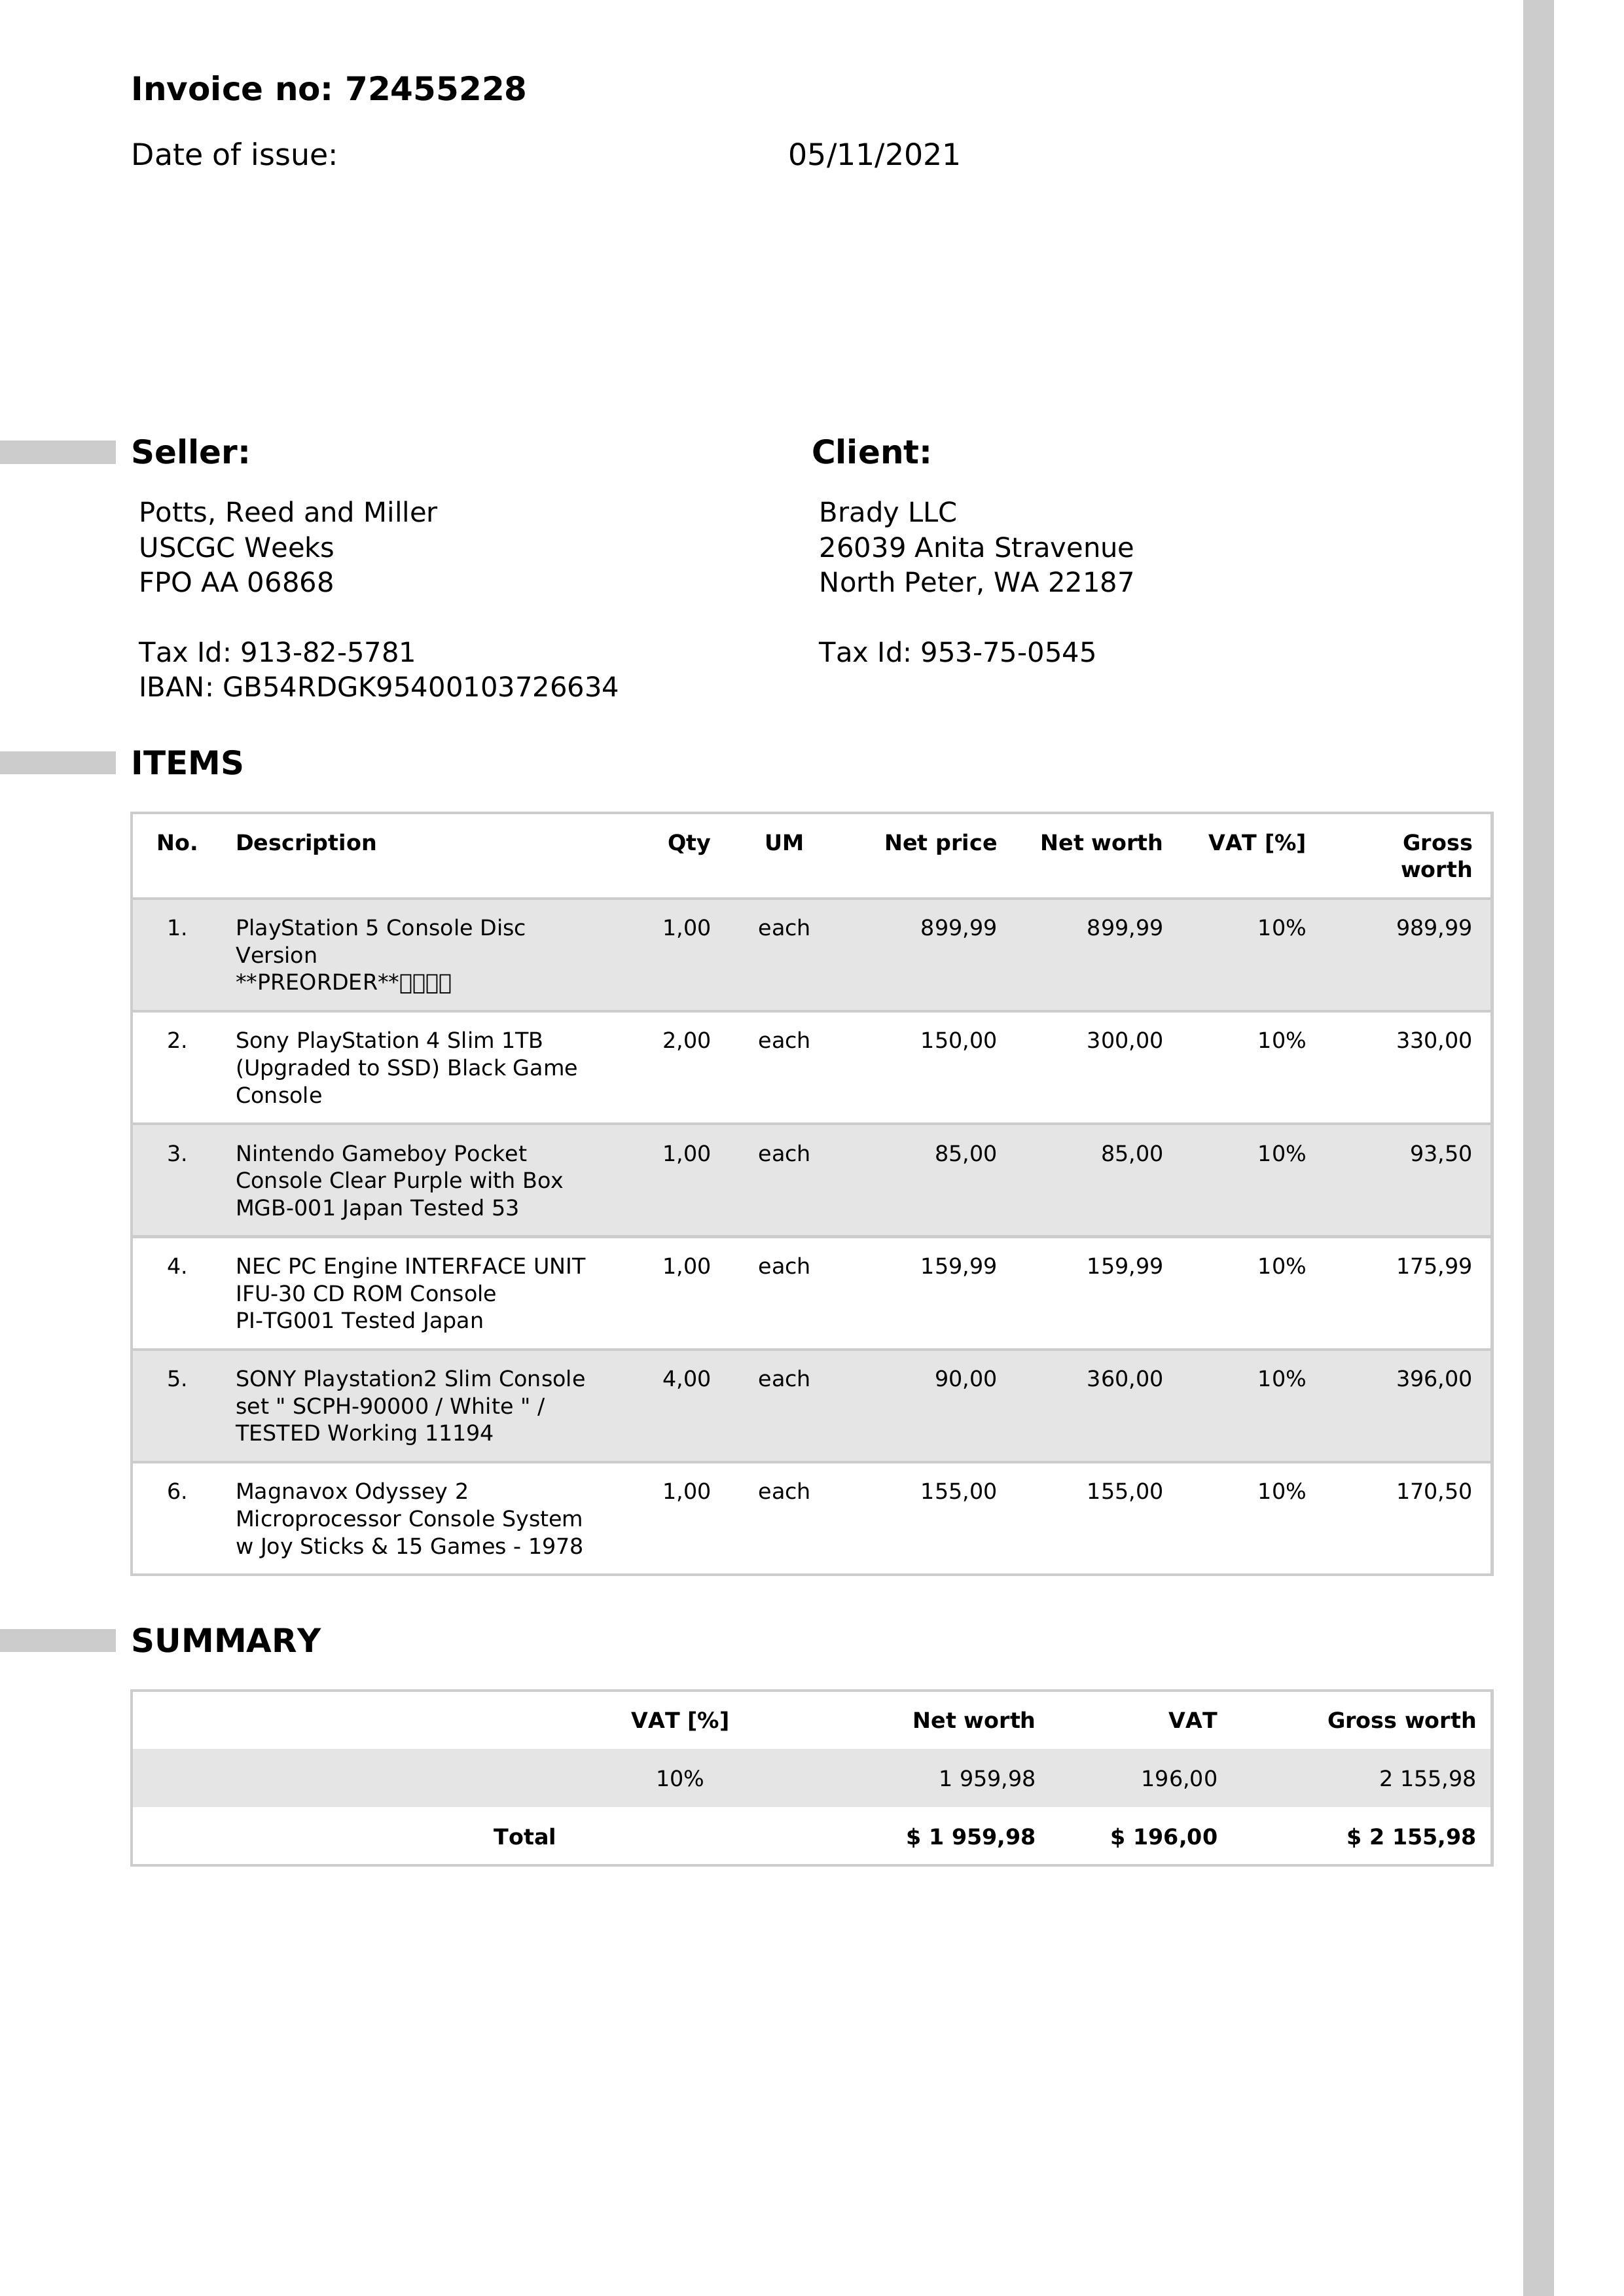

In [ ]:
dataset["test"][10]['image']